In [1]:
from __future__ import division
import nltk
import copy
import re
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from nltk.corpus import brown
from nltk import bigrams, ngrams, trigrams 
from nltk.probability import FreqDist as FreqDist  
from numpy.polynomial.polynomial import polyfit
from collections import Counter
from string import digits
from scipy import stats
import operator
from collections import OrderedDict
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

# Get the Data

In [2]:
from nltk.corpus import treebank,brown

corpus = brown.tagged_sents(tagset='universal')[:-100] 

tag_dict={}
word_dict={}

for sent in corpus:
    for elem in sent:
        w = elem[0]
        tag= elem[1]

        if w not in word_dict:
            word_dict[w]=0

        if tag not in tag_dict:
            tag_dict[tag]=0

        word_dict[w]+=1
        tag_dict[tag]+=1
unigram_prob=dict()
V=len(word_dict)
for word in word_dict.keys():
    unigram_prob[word]=word_dict[word]/V
test_data= brown.tagged_sents(tagset='universal')[-100:]


def sent2labels(sent):
    return [label for _,label in sent]


y_test=[sent2labels(s) for s in test_data]




# Part I: POS Tagging with HMM

## Build the start, emission and transition probability matrices for the HMM

In [3]:
start={}                                               # Start matrix
transition={}                                          # Transition matrix
emission={}                                            # Emission matrix
context={}
for line in corpus:                                    # building the above three matrices from the data
    previous='<s>'
    for word,tag in line:
        if(previous=='<s>'):                           # Handling first tag of the sentence(separately for start matrix)
            if tag not in context:
                context[tag]=0
            context[tag]+=1
            if tag not in start:
                start[tag]=0.0
            start[tag]+=1
            previous=tag
        else:                                          # Rest of the word-tag pairs
            if tag not in context:
                context[tag]=0
            context[tag]+=1
            if previous not in transition:
                transition[previous]={}
            if tag not in transition[previous]:
                transition[previous][tag]=0
            transition[previous][tag]+=1
            previous=tag
        if tag not in emission:
            emission[tag]={}
        if word not in emission[tag]:
            emission[tag][word]=0
        emission[tag][word]+=1
    if '</s>' not in transition[previous]:            # including transitions to the accept state '</s>'
        transition[previous]['</s>']=0
    transition[previous]['</s>']+=1
emission_raw=copy.deepcopy(emission)
for tag in transition:                                 # Normalizing the counts into probability scores
    total_count=float(sum(transition[tag].values())) 
    for next_tag in transition[tag]:
        transition[tag][next_tag]/=(total_count)
for tag in start:                                      # Normalizing the counts into probability scores
    start[tag]/=float(len(corpus))

for tag in emission:                                   # Normalizing the counts into probability scores
    total_count=float(sum(emission[tag].values())) 
    for word in emission[tag]:
        emission[tag][word]/=(total_count)        

## POS Taggging with HMM Model and Additive Smoothing

In [4]:
def smoothed_emission(tag, word,delta):                          # Emission probabilities with additive smoothing
    count_pair=emission_raw[tag].get(word,0)
    prob=(count_pair+delta)/(context[tag]+delta*V)
    return prob

def log(x):
    if (x==0 ):
        return -np.inf
    else:
        return np.log(x)
    
def pos_tagger(sentence,delta):
    viterbi_scores=dict()                                         # Implementation of Viterbi algorithm to find the most probable tag sequence
    backpointer=dict()
    N=len(context.keys())                                         # Number of states except accept state '</s>'
    T=len(sentence)
    words=['dummy']
    words.extend(sentence)
    for s in context.keys():                                      # Initialization Step
        viterbi_scores[s,1]=log((start.get(s,0))*smoothed_emission(s,words[1],delta))
        backpointer[s,1]=0
    for t in range(2,T+1):                                        # Recursion Step
        for s in context.keys():
            max_prob=-np.inf
            for s1 in context.keys():
                prob=viterbi_scores[s1,t-1]
                prob+=log(transition[s1].get(s,0))
                prob+=log(smoothed_emission(s,words[t],delta))
                if(prob>=max_prob):
                    viterbi_scores[s,t]=prob
                    backpointer[s,t]=s1
                    max_prob=prob
    max_prob=-np.inf
    for s in context.keys():                                      # Termination Step                                 
        prob=(viterbi_scores[s,T])+log(transition[s].get('</s>',0))
        if prob>=max_prob:
            max_prob=prob
            viterbi_scores['</s>',T+1]=prob
            backpointer['</s>',T+1]=s      
    tag_sequence=list()
    tag='</s>'
    tag_sequence.append(tag)
    for t in range(T+1,0,-1):                                     # Trace the backpointers to get the tag sequence
        tag=backpointer[tag,t]
        tag_sequence.append(tag)
    tag_sequence.reverse()
    tag_sequence=tag_sequence[1:len(tag_sequence)-1]
    return tag_sequence

## Model States

In [5]:
context.keys()                     # The POS Tags corresponding to the latent states of the HMM

dict_keys(['DET', 'NOUN', 'ADJ', 'VERB', 'ADP', '.', 'ADV', 'CONJ', 'PRT', 'PRON', 'NUM', 'X'])

## Measuring accuracy on the test set

In [6]:
def find_accuracy(predicted_tags, test_tags):
    num_sentences=len(predicted_tags)
    scores=list()
    total_count=0
    num_tags=0
    for i in range(num_sentences):
        count=0
        predicted=predicted_tags[i]
        test=test_tags[i]
        len_sentence=len(test)
        for j in range(len_sentence):
            if(predicted[j]==test[j]):
                count+=1
                total_count+=1
        scores.append(count/len_sentence)
        num_tags+=len_sentence
    print(total_count/num_tags)
    return np.mean(np.asarray(scores))

In [7]:
test_sentences=[[word[0] for word in sentence] for sentence in test_data]
test_tags=[[word[1] for word in sentence] for sentence in test_data]

In [8]:
predicted_tags=[pos_tagger(sentence,0.001) for sentence in test_sentences]

In [9]:
metrics.flat_f1_score(y_test, predicted_tags,average='weighted')

0.9252161317133518

In [10]:

print(metrics.flat_classification_report( y_test, predicted_tags, digits=3
))

             precision    recall  f1-score   support

          .      0.977     0.997     0.987       334
        ADJ      0.804     0.879     0.840       140
        ADP      0.951     0.958     0.954       283
        ADV      0.797     0.823     0.810       124
       CONJ      0.913     1.000     0.955        84
        DET      0.977     0.990     0.983       295
       NOUN      0.953     0.849     0.898       483
        NUM      0.455     0.952     0.615        21
       PRON      0.958     0.994     0.975       160
        PRT      0.890     0.929     0.909        70
       VERB      0.962     0.884     0.921       370
          X      0.367     0.647     0.468        17

avg / total      0.932     0.923     0.925      2381



# Part II: POS Tagging with CRF

In [3]:
train_sents= corpus

def baselineFeatures(sent,i):
    word = sent[i][0]
    postag = sent[i][1]

    # Common features for all words
    features = {
        'bias':1.0,
        'word.lower': word.lower(),
    }
    return features
 
def word2features(sent,i):
    word = sent[i][0]
    postag = sent[i][1]

    # Common features for all words
    features = {
        'bias':1.0,
        'word': word.lower(),
        'prefix-2':word[:2],
        'prefix-3':word[:3],
        'suffix-1':word[-1],
        'suffix-2':word[-2:],
        'suffix-3':word[-3:],
        'has_hyphen': '-' in word,
        'word.isupper': word.isupper(),
        'word.istitle': word.istitle(),
        'word.isdigit': word.isdigit(),
    }

    # Features for words that are not
    # at the beginning of a sentument
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            'previous_word' : word1.lower(),
            'prev_prefix-2':word1[:2],
            'prev_prefix-3':word1[:3],
            'prev_suffix-1':word1[-1],
            'prev_suffix-2':word1[-2:],
           'prev_suffix-3':word1[-3:],
            'prev_word.istitle' : word1.istitle(),
            'prev_word.isupper' : word1.isupper(),
            'prev_word.isdigit' : word1.isdigit(),
            
        })
    else:
        # Indicate that it is the 'beginning of a sentence'
        features.update({'BOS':True})

    # Features for words that are not
    # at the end of a sentument
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            'next_word.lower': word1.lower(),
            'next_prefix-2':word1[:2],
            'next_prefix-3':word1[:3],
            'next_suffix-1':word1[-1],
            'next_suffix-2':word1[-2:],
            'next_suffix-3':word1[-3:],
           'next_word.istitle' :word1.istitle(),
           'next_word.isupper' : word1.isupper(),
           'next_word.isdigit' : word1.isdigit(),
            
        })
    else:
        # Indicate that it is the 'end of a sentument'
        features.update({'EOS':True})

    return features


def sent2features(sent,baseline=False):
    if(baseline):
        return [baselineFeatures(sent,i) for i in range(len(sent))]
    return [word2features(sent,i) for i in range(len(sent))]

In [4]:
X_train=[sent2features(s) for s in train_sents]

y_train=[sent2labels(s) for s in train_sents]

X_test=[sent2features(s) for s in test_data]

In [5]:

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [6]:
y_pred = crf.predict(X_test)
labels=list(crf.classes_)

metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.9582535866534301

In [7]:
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)

In [8]:

print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          .      1.000     1.000     1.000       334
          X      1.000     0.176     0.300        17
        ADJ      0.861     0.886     0.873       140
        ADP      0.968     0.975     0.972       283
        ADV      0.924     0.879     0.901       124
       VERB      0.975     0.938     0.956       370
        DET      0.997     1.000     0.998       295
       CONJ      1.000     0.976     0.988        84
       NOUN      0.927     0.967     0.946       483
       PRON      1.000     1.000     1.000       160
        PRT      0.883     0.971     0.925        70
        NUM      0.955     1.000     0.977        21

avg / total      0.961     0.960     0.958      2381



## Hyperparameter Search

In [12]:
%%time
crf1 = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf1, params_space,
                        cv=3,
                        verbose=8,
                        n_jobs=1,
                        n_iter=20,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] c1=0.3750756963753804, c2=0.004186602148178022 ..................
[CV]  c1=0.3750756963753804, c2=0.004186602148178022, score=0.9730147538922558, total= 4.0min
[CV] c1=0.3750756963753804, c2=0.004186602148178022 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


[CV]  c1=0.3750756963753804, c2=0.004186602148178022, score=0.9751866126648254, total= 3.7min
[CV] c1=0.3750756963753804, c2=0.004186602148178022 ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.3min remaining:    0.0s


[CV]  c1=0.3750756963753804, c2=0.004186602148178022, score=0.9728417359456751, total= 4.6min
[CV] c1=0.027057276857226205, c2=0.01308423634103991 .................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.2min remaining:    0.0s


[CV]  c1=0.027057276857226205, c2=0.01308423634103991, score=0.970883697331713, total= 3.9min
[CV] c1=0.027057276857226205, c2=0.01308423634103991 .................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 17.5min remaining:    0.0s


[CV]  c1=0.027057276857226205, c2=0.01308423634103991, score=0.9738349823650709, total= 4.2min
[CV] c1=0.027057276857226205, c2=0.01308423634103991 .................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 22.0min remaining:    0.0s


[CV]  c1=0.027057276857226205, c2=0.01308423634103991, score=0.9719800363240984, total= 5.2min
[CV] c1=0.11052146942408986, c2=0.08898981749301955 ..................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 27.5min remaining:    0.0s


[CV]  c1=0.11052146942408986, c2=0.08898981749301955, score=0.9721245809117803, total= 3.9min
[CV] c1=0.11052146942408986, c2=0.08898981749301955 ..................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 31.7min remaining:    0.0s


[CV]  c1=0.11052146942408986, c2=0.08898981749301955, score=0.9745849918359509, total= 3.8min
[CV] c1=0.11052146942408986, c2=0.08898981749301955 ..................
[CV]  c1=0.11052146942408986, c2=0.08898981749301955, score=0.972021720235731, total= 4.8min
[CV] c1=0.19769190429297595, c2=0.05475542511149445 ..................
[CV]  c1=0.19769190429297595, c2=0.05475542511149445, score=0.9727294060590894, total= 4.4min
[CV] c1=0.19769190429297595, c2=0.05475542511149445 ..................
[CV]  c1=0.19769190429297595, c2=0.05475542511149445, score=0.9748727658621332, total= 4.1min
[CV] c1=0.19769190429297595, c2=0.05475542511149445 ..................
[CV]  c1=0.19769190429297595, c2=0.05475542511149445, score=0.9723959328824507, total= 4.8min
[CV] c1=0.9867476227124493, c2=0.011227156621950741 ..................
[CV]  c1=0.9867476227124493, c2=0.011227156621950741, score=0.9721769574176718, total= 4.0min
[CV] c1=0.9867476227124493, c2=0.011227156621950741 ..................
[CV]  c1=0.

[CV]  c1=0.8702202130798201, c2=0.041512640564092686, score=0.9720467696592147, total= 4.0min
[CV] c1=0.8702202130798201, c2=0.041512640564092686 ..................
[CV]  c1=0.8702202130798201, c2=0.041512640564092686, score=0.9746834442453632, total= 3.9min
[CV] c1=0.8702202130798201, c2=0.041512640564092686 ..................
[CV]  c1=0.8702202130798201, c2=0.041512640564092686, score=0.9711496363422599, total= 4.6min


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 277.3min finished


CPU times: user 4h 44min 44s, sys: 36.6 s, total: 4h 45min 20s
Wall time: 4h 43min 33s


In [13]:
crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)

best params: {'c1': 0.3750756963753804, 'c2': 0.004186602148178022}
best CV score: 0.9736810341675853


In [14]:
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          .      1.000     1.000     1.000       334
          X      0.875     0.412     0.560        17
        ADJ      0.848     0.879     0.863       140
        ADP      0.975     0.979     0.977       283
        ADV      0.923     0.871     0.896       124
       VERB      0.969     0.943     0.956       370
        DET      0.997     1.000     0.998       295
       CONJ      1.000     0.976     0.988        84
       NOUN      0.936     0.963     0.949       483
       PRON      1.000     1.000     1.000       160
        PRT      0.895     0.971     0.932        70
        NUM      0.955     1.000     0.977        21

avg / total      0.962     0.961     0.961      2381



/home/cules/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/cules/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/cules/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Dark blue => 0.9709, dark red => 0.9737


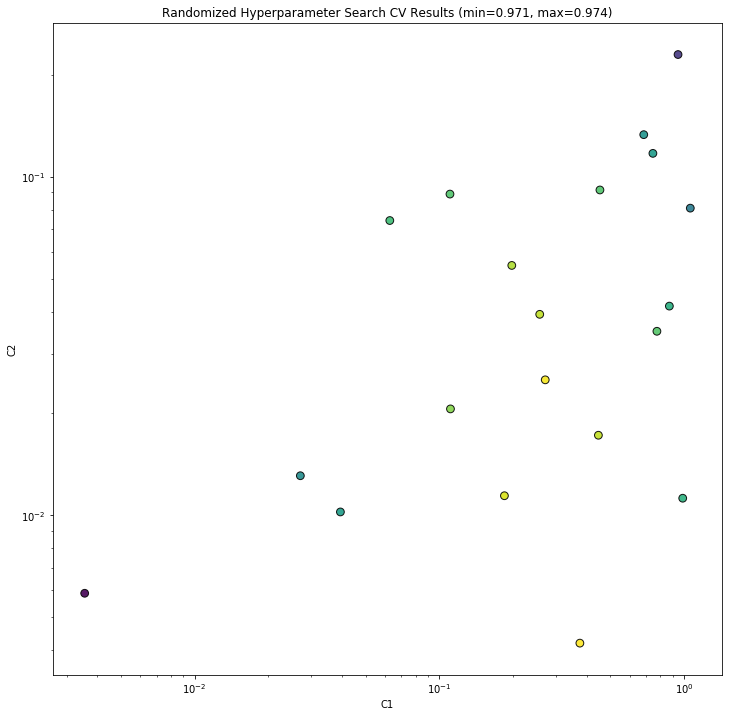

In [15]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))
